# 5. Classification

This section develops a classification model to predict diabetes risk. A staged decision-making pipeline is used, where each stage locks in one choice before proceeding to the next.

---
### Pipeline Overview

| Stage | Question | Metric | Rationale |
|-------|----------|--------|-----------|
| 1. Target formulation | Binary vs Multiclass? | Macro-F1 | Fair across different class structures; recall alone would penalise multiclass due to small prediabetes class |
| 2. Feature selection | Engineered vs Raw vs RFE? | Recall | Once binary is confirmed, screening sensitivity becomes the priority; fewer features preferred for interpretability |
| 3. Resampling strategy | None / SMOTE / ROS / Class Weights? | Recall | Feature set fixed; identify the imbalance-handling approach that maximises sensitivity |
| 4. Hyperparameter tuning | Optimise the winning model | Recall | Model, features, and resampling fixed; fine-tune for best screening performance |

After Stage 4 the final model undergoes calibration, threshold optimisation, explainability analysis, and triage.

---
## 5.1 Setup and Configuration

In [169]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from pathlib import Path

# Sklearn - preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Sklearn - metrics
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_auc_score,
    log_loss, roc_curve, auc
)

# Sklearn - calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Sklearn - feature selection
from sklearn.feature_selection import RFECV

# Imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Explainability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_FOLDS = 5
FIGURES_DIR = Path('figures')
DATA_DIR = Path('data')
FIGURES_DIR.mkdir(exist_ok=True)

# Cost parameters for clinical decision making

COST_FP = 5.0    # Cost of false positive (flagging healthy as at-risk)
COST_FN = 25.0   # Cost of false negative (missing at-risk individual)
COST_REVIEW = 2.0  # Cost of sending case for human review

print("Setup complete.")

Setup complete.


---
## 5.2 Data Loading

Both the raw CDC features and the engineered features from Notebook 2 are loaded for comparison.

In [170]:
# Load raw data
df_raw = pd.read_csv('CDC Diabetes Dataset (4).csv')
print(f"Raw dataset shape: {df_raw.shape}")

# Load engineered features from notebook 2
df_engineered = pd.read_csv(DATA_DIR / 'classification_features.csv')
print(f"Engineered dataset shape: {df_engineered.shape}")

# Display engineered features
print(f"\nEngineered features: {list(df_engineered.columns)}")

Raw dataset shape: (253680, 22)
Engineered dataset shape: (253680, 14)

Engineered features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck', 'Diabetes_012']


In [171]:
# Define feature columns
# Exclude features identified in Data Understanding as having reverse causality / survivorship bias:
# - Stroke, HeartDiseaseorAttack: downstream consequences of diabetes (reverse causality)
# - HvyAlcoholConsump: inverse association due to survivorship bias
EXCLUDED_FEATURES = ['Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump']
RAW_FEATURE_COLS = [col for col in df_raw.columns if col not in ['Diabetes_012'] + EXCLUDED_FEATURES]
ENGINEERED_FEATURE_COLS = [col for col in df_engineered.columns if col != 'Diabetes_012']

print(f"Excluded from raw features (reverse causality / survivorship bias): {EXCLUDED_FEATURES}")
print(f"Raw features ({len(RAW_FEATURE_COLS)}): {RAW_FEATURE_COLS}")
print(f"\nEngineered features ({len(ENGINEERED_FEATURE_COLS)}): {ENGINEERED_FEATURE_COLS}")

Excluded from raw features (reverse causality / survivorship bias): ['Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump']
Raw features (18): ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Engineered features (13): ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck']


---
## 5.2.1 Recursive Feature Elimination (RFE)

RFECV is applied to the raw features to identify the most predictive subset, providing a parsimonious alternative to the full feature sets. Fewer features improve interpretability, making it easier to communicate which factors drive predictions.

In [172]:
# Recursive Feature Elimination with Cross-Validation (RFECV)
# Applied to raw features to identify optimal feature subset

print("=== RFECV on Raw Features ===\n")

# Create binary target for RFE
df_raw['at_risk'] = (df_raw['Diabetes_012'] >= 1).astype(int)

X_raw = df_raw[RAW_FEATURE_COLS]
y_raw_binary = df_raw['at_risk']

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_raw, y_raw_binary, test_size=TEST_SIZE, stratify=y_raw_binary, random_state=RANDOM_STATE
)

cv_rfe = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scale features first, then run RFECV on scaled data
# Using RandomForest as the estimator — it provides feature importance rankings
# that produce more meaningful elimination than LogisticRegression
scaler_rfe = StandardScaler()
X_train_rfe_scaled = scaler_rfe.fit_transform(X_train_rfe)

rfecv = RFECV(
    estimator=RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1
    ),
    step=1,
    cv=cv_rfe,
    scoring="recall",  # Prioritize recall to minimize missed at-risk individuals
    min_features_to_select=5,  # At least 5 features for a meaningful model
    n_jobs=-1
)

print("Running RFECV... (this may take a moment)")
rfecv.fit(X_train_rfe_scaled, y_train_rfe)

print(f"\nOptimal number of features: {rfecv.n_features_}")
print(f"Best CV score (Recall): {rfecv.cv_results_['mean_test_score'].max():.4f}")

selected_mask = rfecv.support_
selected_features = [f for f, s in zip(RAW_FEATURE_COLS, selected_mask) if s]
eliminated_features = [f for f, s in zip(RAW_FEATURE_COLS, selected_mask) if not s]

print(f"\nSelected features ({len(selected_features)}):")
for f in selected_features:
    print(f"  - {f}")

if eliminated_features:
    print(f"\nEliminated features ({len(eliminated_features)}):")
    for f in eliminated_features:
        print(f"  - {f}")

feature_ranking = pd.DataFrame({
    'Feature': RAW_FEATURE_COLS,
    'Selected': rfecv.support_,
    'Rank': rfecv.ranking_
}).sort_values('Rank')

print("\nFeature rankings (1 = selected):")
print(feature_ranking.to_string(index=False))

=== RFECV on Raw Features ===

Running RFECV... (this may take a moment)

Optimal number of features: 5
Best CV score (Recall): 0.1018

Selected features (5):
  - HighBP
  - HighChol
  - BMI
  - GenHlth
  - DiffWalk

Eliminated features (13):
  - CholCheck
  - Smoker
  - PhysActivity
  - Fruits
  - Veggies
  - AnyHealthcare
  - NoDocbcCost
  - MentHlth
  - PhysHlth
  - Sex
  - Age
  - Education
  - Income

Feature rankings (1 = selected):
      Feature  Selected  Rank
       HighBP      True     1
     HighChol      True     1
          BMI      True     1
      GenHlth      True     1
     DiffWalk      True     1
          Age     False     2
     PhysHlth     False     3
       Income     False     4
    Education     False     5
 PhysActivity     False     6
    CholCheck     False     7
          Sex     False     8
     MentHlth     False     9
       Smoker     False    10
      Veggies     False    11
       Fruits     False    12
AnyHealthcare     False    13
  NoDocbcCost    

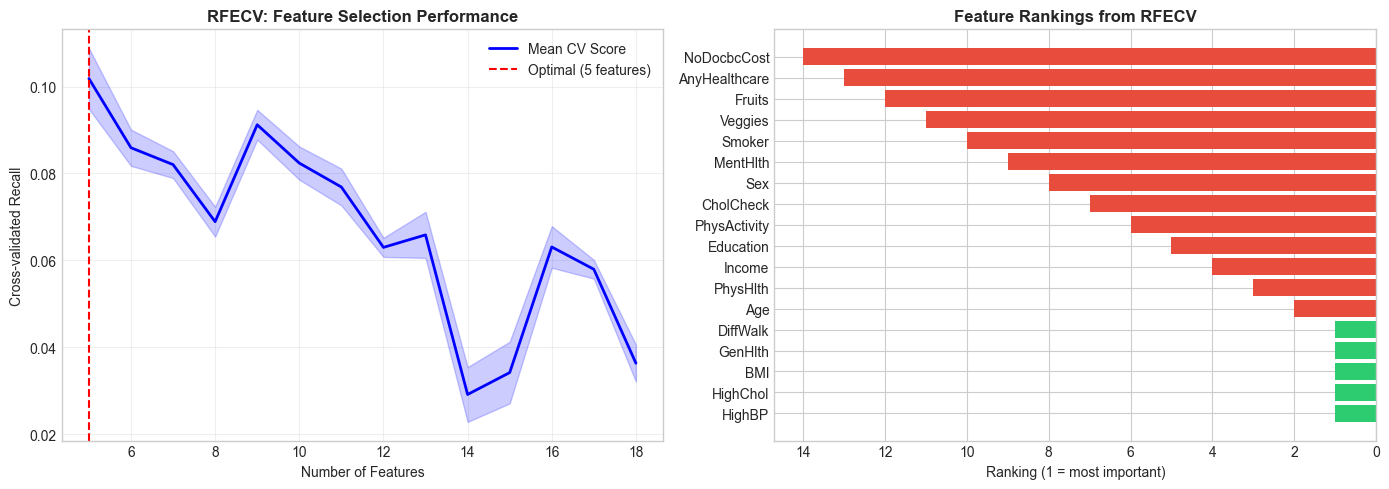


RFE-selected features stored: 5 features
Interpretability benefit: 13 fewer features than full raw set


In [173]:
# Visualize RFECV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot CV scores vs number of features
# Handle different sklearn versions for accessing scores
if hasattr(rfecv, "cv_results_") and "mean_test_score" in rfecv.cv_results_:
    scores = rfecv.cv_results_["mean_test_score"]
    n_features = rfecv.cv_results_.get("n_features", range(1, len(scores) + 1))
    std_scores = rfecv.cv_results_.get("std_test_score", np.zeros_like(scores))
elif hasattr(rfecv, "grid_scores_"):
    scores = rfecv.grid_scores_
    n_features = range(1, len(scores) + 1)
    std_scores = np.zeros_like(scores)
else:
    scores = rfecv.cv_results_["mean_test_score"]
    n_features = range(rfecv.min_features_to_select, rfecv.min_features_to_select + len(scores))
    std_scores = rfecv.cv_results_.get("std_test_score", np.zeros_like(scores))

axes[0].plot(n_features, scores, 'b-', linewidth=2, label='Mean CV Score')
axes[0].fill_between(n_features, 
                      scores - std_scores, 
                      scores + std_scores, 
                      alpha=0.2, color='blue')
axes[0].axvline(x=rfecv.n_features_, color='red', linestyle='--', label=f'Optimal ({rfecv.n_features_} features)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Cross-validated Recall')
axes[0].set_title('RFECV: Feature Selection Performance', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of feature importance (by rank)
colors = ['#2ecc71' if s else '#e74c3c' for s in rfecv.support_]
sorted_idx = np.argsort(rfecv.ranking_)
axes[1].barh(range(len(RAW_FEATURE_COLS)), 
             [rfecv.ranking_[i] for i in sorted_idx],
             color=[colors[i] for i in sorted_idx])
axes[1].set_yticks(range(len(RAW_FEATURE_COLS)))
axes[1].set_yticklabels([RAW_FEATURE_COLS[i] for i in sorted_idx])
axes[1].set_xlabel('Ranking (1 = most important)')
axes[1].set_title('Feature Rankings from RFECV', fontweight='bold')
axes[1].invert_xaxis()  # Lower rank = better

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rfecv_feature_selection.png', dpi=150, bbox_inches='tight')
plt.show()

# Store selected features for later use
RFE_SELECTED_FEATURES = selected_features.copy()
print(f"\nRFE-selected features stored: {len(RFE_SELECTED_FEATURES)} features")
print(f"Interpretability benefit: {len(RAW_FEATURE_COLS) - len(RFE_SELECTED_FEATURES)} fewer features than full raw set")

---
## 5.3 Target Variable Creation

Two target variables are defined:
- Binary (at_risk): prediabetes and diabetes combined into a single at-risk class.
- Multiclass: original 3-class target (0 = Healthy, 1 = Prediabetes, 2 = Diabetes).

In [174]:
# Create binary target: At-Risk (prediabetes + diabetes) vs Healthy
df_raw['at_risk'] = (df_raw['Diabetes_012'] >= 1).astype(int)
df_engineered['at_risk'] = (df_engineered['Diabetes_012'] >= 1).astype(int)

# Display class distributions
print("=== Multiclass Target Distribution ===")
print(df_raw['Diabetes_012'].value_counts().sort_index())
print(f"\nClass proportions:")
print(df_raw['Diabetes_012'].value_counts(normalize=True).sort_index().round(4))

print("\n=== Binary Target Distribution (At-Risk) ===")
print(df_raw['at_risk'].value_counts().sort_index())
print(f"\nClass proportions:")
print(df_raw['at_risk'].value_counts(normalize=True).sort_index().round(4))

=== Multiclass Target Distribution ===
Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64

Class proportions:
Diabetes_012
0.0    0.8424
1.0    0.0183
2.0    0.1393
Name: proportion, dtype: float64

=== Binary Target Distribution (At-Risk) ===
at_risk
0    213703
1     39977
Name: count, dtype: int64

Class proportions:
at_risk
0    0.8424
1    0.1576
Name: proportion, dtype: float64


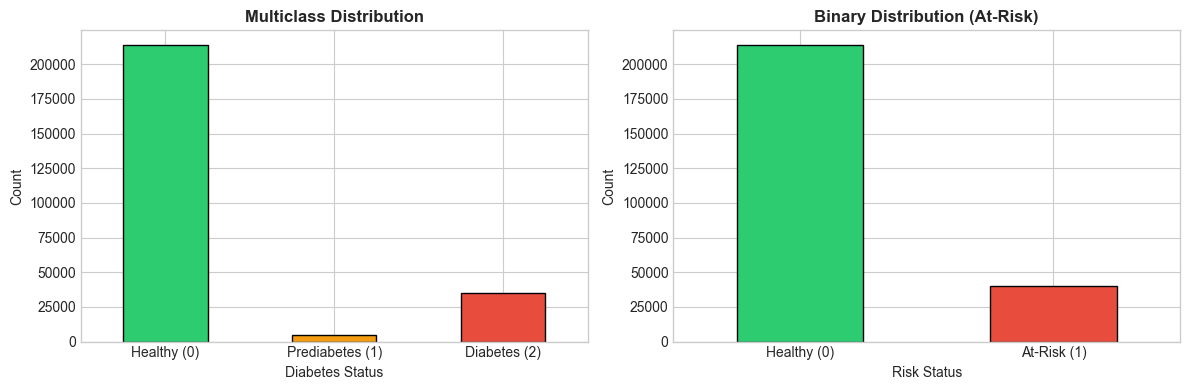

In [175]:
# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Multiclass
class_labels_multi = ['Healthy (0)', 'Prediabetes (1)', 'Diabetes (2)']
colors_multi = ['#2ecc71', '#f39c12', '#e74c3c']
df_raw['Diabetes_012'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=colors_multi, edgecolor='black'
)
axes[0].set_title('Multiclass Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Diabetes Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(class_labels_multi, rotation=0)

# Binary
class_labels_binary = ['Healthy (0)', 'At-Risk (1)']
colors_binary = ['#2ecc71', '#e74c3c']
df_raw['at_risk'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=colors_binary, edgecolor='black'
)
axes[1].set_title('Binary Distribution (At-Risk)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Risk Status')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(class_labels_binary, rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'class_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.4 Train/Test Split

Train/test splits are created for all five experimental tracks (A--E).

In [176]:
# Define track configurations
# Track E uses RFE-selected features from Section 5.2.1 (requires running that section first)
track_configs = {
    'A': {'name': 'Binary + Engineered',     'features': ENGINEERED_FEATURE_COLS, 'target': 'at_risk',      'df': df_engineered, 'n_classes': 2},
    'B': {'name': 'Binary + Raw',            'features': RAW_FEATURE_COLS,        'target': 'at_risk',      'df': df_raw,        'n_classes': 2},
    'C': {'name': 'Multiclass + Engineered', 'features': ENGINEERED_FEATURE_COLS, 'target': 'Diabetes_012', 'df': df_engineered, 'n_classes': 3},
    'D': {'name': 'Multiclass + Raw',        'features': RAW_FEATURE_COLS,        'target': 'Diabetes_012', 'df': df_raw,        'n_classes': 3},
    'E': {'name': 'Binary + RFE-Selected',   'features': RFE_SELECTED_FEATURES,   'target': 'at_risk',      'df': df_raw,        'n_classes': 2},
}

# Create datasets using configuration
datasets = {}
for track_id, config in track_configs.items():
    X = config['df'][config['features']]
    y = config['df'][config['target']]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    datasets[track_id] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'name': config['name'],
        'n_classes': config['n_classes'],
        'features': config['features']
    }

# Summary
print("=== Dataset Summary ===")

for track, data in datasets.items():
    print(f"Track {track} ({data['name']}): Train={len(data['X_train'])}, Test={len(data['X_test'])}, Features={len(data['features'])}")

=== Dataset Summary ===
Track A (Binary + Engineered): Train=202944, Test=50736, Features=13
Track B (Binary + Raw): Train=202944, Test=50736, Features=18
Track C (Multiclass + Engineered): Train=202944, Test=50736, Features=13
Track D (Multiclass + Raw): Train=202944, Test=50736, Features=18
Track E (Binary + RFE-Selected): Train=202944, Test=50736, Features=5


---
## 5.5 Model Training Functions

Helper functions for training models with different resampling strategies.

In [177]:
def get_resampling_pipeline(model, resampling_method, n_classes=2):
    """
    Create a pipeline with scaling and optional resampling.
    
    Parameters:
    -----------
    model : sklearn estimator
        The classifier to use
    resampling_method : str
        One of: 'none', 'smote', 'ros', 'class_weight'
    n_classes : int
        Number of classes (2 for binary, 3 for multiclass)
    
    Returns:
    --------
    pipeline : Pipeline or ImbPipeline
    """
    # Determine k_neighbors for SMOTE based on minority class
    k_neighbors = 3 if n_classes == 3 else 5
    
    if resampling_method == 'none':
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    elif resampling_method == 'smote':
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('resampler', SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)),
            ('classifier', model)
        ])
    elif resampling_method == 'ros':
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('resampler', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', model)
        ])
    elif resampling_method == 'class_weight':
        # Clone model with class_weight='balanced'
        model_params = model.get_params()
        model_params['class_weight'] = 'balanced'
        balanced_model = model.__class__(**model_params)
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', balanced_model)
        ])
    else:
        raise ValueError(f"Unknown resampling method: {resampling_method}")


def evaluate_model(model, X_test, y_test, n_classes=2):
    """
    Evaluate a trained model and return metrics dictionary.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro'),
        'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
        'macro_recall': recall_score(y_test, y_pred, average='macro'),
        'log_loss': log_loss(y_test, y_proba),
    }
    
    # ROC-AUC (handle binary vs multiclass)
    if n_classes == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
    else:
        # One-vs-Rest for multiclass
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        metrics['roc_auc'] = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    
    return metrics, y_pred, y_proba


def train_and_evaluate(X_train, X_test, y_train, y_test, model, resampling_method, n_classes=2):
    """
    Train model with resampling and evaluate.
    """
    start_time = time.time()
    
    pipeline = get_resampling_pipeline(model, resampling_method, n_classes)
    pipeline.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    metrics, y_pred, y_proba = evaluate_model(pipeline, X_test, y_test, n_classes)
    metrics['train_time'] = train_time
    
    return pipeline, metrics, y_pred, y_proba

print("Training functions defined.")

Training functions defined.


---
## 5.6 Stage 1: Binary vs Multiclass

Should the target be 3 classes (Healthy / Prediabetes / Diabetes) or 2 classes (Healthy / At-Risk)?

Macro-F1 is used as the comparison metric because it balances precision and recall equally across all classes. Recall alone would penalise multiclass unfairly due to the small prediabetes class (1.8%). All three algorithms are trained with no resampling on binary (Track B) and multiclass (Track D) using raw features.

In [178]:
from sklearn.base import clone

# -- Stage 1: Binary vs Multiclass (no resampling, raw features only) --
# Compare using Macro-F1 as the fair metric across different class structures

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE, 
                             eval_metric='logloss', verbosity=0)
}

stage1_results = []
trained_models = {}

print("=" * 60)
print("STAGE 1: Binary vs Multiclass (Macro-F1, no resampling)")
print("=" * 60)

# Only compare raw features for binary (B) vs multiclass (D) — same feature set, different targets
for track_id in ['B', 'D']:
    track_data = datasets[track_id]
    print(f"\n=== Track {track_id}: {track_data['name']} ===")
    trained_models[track_id] = {}
    
    for model_name, model in base_models.items():
        model_copy = clone(model)
        pipeline, metrics, y_pred, y_proba = train_and_evaluate(
            track_data['X_train'], track_data['X_test'],
            track_data['y_train'], track_data['y_test'],
            model_copy, resampling_method='none', n_classes=track_data['n_classes']
        )
        
        stage1_results.append({
            'track': track_id,
            'track_name': track_data['name'],
            'formulation': 'Binary' if track_data['n_classes'] == 2 else 'Multiclass',
            'model': model_name,
            'macro_f1': metrics['macro_f1'],
            'macro_recall': metrics['macro_recall'],
            'roc_auc': metrics['roc_auc'],
            'accuracy': metrics['accuracy']
        })
        trained_models[track_id][f"{model_name}_none"] = pipeline
        
        print(f"  {model_name}: Macro-F1={metrics['macro_f1']:.4f}, Recall={metrics['macro_recall']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

stage1_df = pd.DataFrame(stage1_results)

STAGE 1: Binary vs Multiclass (Macro-F1, no resampling)

=== Track B: Binary + Raw ===
  Logistic Regression: Macro-F1=0.5953, Recall=0.5779, ROC-AUC=0.8149
  Random Forest: Macro-F1=0.5653, Recall=0.5571, ROC-AUC=0.8188
  XGBoost: Macro-F1=0.6018, Recall=0.5823, ROC-AUC=0.8220

=== Track D: Multiclass + Raw ===
  Logistic Regression: Macro-F1=0.3868, Recall=0.3794, ROC-AUC=0.7793
  Random Forest: Macro-F1=0.3657, Recall=0.3651, ROC-AUC=0.7816
  XGBoost: Macro-F1=0.3915, Recall=0.3825, ROC-AUC=0.7856


DECISION 1: Binary vs Multiclass

Macro-F1 by formulation and model:
formulation          Binary  Multiclass
model                                  
Logistic Regression  0.5953      0.3868
Random Forest        0.5653      0.3657
XGBoost              0.6018      0.3915

Average Macro-F1:  Binary = 0.5875  |  Multiclass = 0.3813
Difference: +0.2061


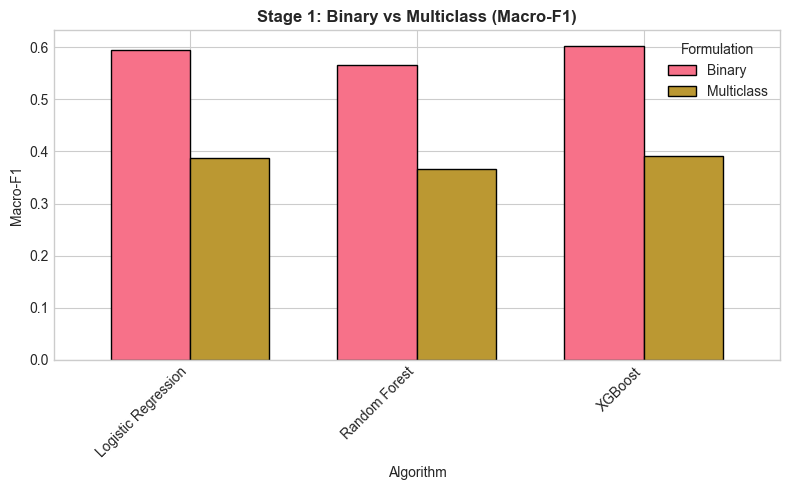


DECISION: Binary formulation selected (Macro-F1: 0.5875 vs 0.3813)
  Multiclass struggles with prediabetes (1.8% prevalence, overlapping features).

From here on, recall is the primary metric (screening priority).


In [202]:
# -- DECISION 1: Binary vs Multiclass --
print("=" * 60)
print("DECISION 1: Binary vs Multiclass")
print("=" * 60)

# Compare average Macro-F1 across all 3 algorithms
pivot = stage1_df.pivot_table(index='model', columns='formulation', values='macro_f1')
print("\nMacro-F1 by formulation and model:")
print(pivot.round(4).to_string())

binary_avg = stage1_df[stage1_df['formulation'] == 'Binary']['macro_f1'].mean()
multi_avg = stage1_df[stage1_df['formulation'] == 'Multiclass']['macro_f1'].mean()

print(f"\nAverage Macro-F1:  Binary = {binary_avg:.4f}  |  Multiclass = {multi_avg:.4f}")
print(f"Difference: {binary_avg - multi_avg:+.4f}")

# Visualise
fig, ax = plt.subplots(figsize=(8, 5))
pivot.plot(kind='bar', ax=ax, width=0.7, edgecolor='black')
ax.set_title('Stage 1: Binary vs Multiclass (Macro-F1)', fontweight='bold')
ax.set_ylabel('Macro-F1')
ax.set_xlabel('Algorithm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Formulation')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage1_binary_vs_multiclass.png', dpi=150, bbox_inches='tight')
plt.show()

# Lock in decision
if binary_avg >= multi_avg:
    CHOSEN_FORMULATION = 'binary'
    CHOSEN_TARGET = 'at_risk'
    CHOSEN_N_CLASSES = 2
    print(f"\nDECISION: Binary formulation selected (Macro-F1: {binary_avg:.4f} vs {multi_avg:.4f})")
    print("  Multiclass struggles with prediabetes (1.8% prevalence, overlapping features).")
else:
    CHOSEN_FORMULATION = 'multiclass'
    CHOSEN_TARGET = 'Diabetes_012'
    CHOSEN_N_CLASSES = 3
    print(f"\nDECISION: Multiclass formulation selected (Macro-F1: {multi_avg:.4f} vs {binary_avg:.4f})")

print(f"\nFrom here on, recall is the primary metric (screening priority).")

---
## 5.7 Stage 2: Feature Set Comparison

Binary formulation is locked in from Stage 1. The question is now which feature set produces the best screening model.

Recall is the metric from this point onward, since the screening priority is maximising sensitivity. Three feature sets are compared: Engineered (Track A), Raw (Track B), and RFE-Selected (Track E). If recall is comparable (within 2%), the smaller feature set is preferred for interpretability. No resampling is applied, to isolate the feature set effect.

In [203]:
from sklearn.base import clone

# -- Stage 2: Feature set comparison (binary only, no resampling, recall metric) --

stage2_results = []

print("=" * 60)
print("STAGE 2: Feature Set Comparison (Recall, no resampling)")
print("=" * 60)

for track_id in ['A', 'B', 'E']:  # Binary tracks only
    track_data = datasets[track_id]
    n_feats = len(track_data['features'])
    print(f"\n=== Track {track_id}: {track_data['name']} ({n_feats} features) ===")
    trained_models[track_id] = trained_models.get(track_id, {})
    
    for model_name, model in base_models.items():
        model_copy = clone(model)
        pipeline, metrics, y_pred, y_proba = train_and_evaluate(
            track_data['X_train'], track_data['X_test'],
            track_data['y_train'], track_data['y_test'],
            model_copy, resampling_method='none', n_classes=2
        )
        
        stage2_results.append({
            'track': track_id,
            'track_name': track_data['name'],
            'feature_set': track_data['name'].replace('Binary + ', ''),
            'n_features': n_feats,
            'model': model_name,
            'macro_recall': metrics['macro_recall'],
            'macro_f1': metrics['macro_f1'],
            'roc_auc': metrics['roc_auc'],
        })
        trained_models[track_id][f"{model_name}_none"] = pipeline
        
        print(f"  {model_name}: Recall={metrics['macro_recall']:.4f}, F1={metrics['macro_f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

stage2_df = pd.DataFrame(stage2_results)

STAGE 2: Feature Set Comparison (Recall, no resampling)

=== Track A: Binary + Engineered (13 features) ===
  Logistic Regression: Recall=0.5806, F1=0.5990, ROC-AUC=0.8124
  Random Forest: Recall=0.5610, F1=0.5716, ROC-AUC=0.8153
  XGBoost: Recall=0.5781, F1=0.5959, ROC-AUC=0.8172

=== Track B: Binary + Raw (18 features) ===
  Logistic Regression: Recall=0.5779, F1=0.5953, ROC-AUC=0.8149
  Random Forest: Recall=0.5571, F1=0.5653, ROC-AUC=0.8188
  XGBoost: Recall=0.5823, F1=0.6018, ROC-AUC=0.8220

=== Track E: Binary + RFE-Selected (5 features) ===
  Logistic Regression: Recall=0.5707, F1=0.5856, ROC-AUC=0.7995
  Random Forest: Recall=0.5684, F1=0.5824, ROC-AUC=0.8017
  XGBoost: Recall=0.5683, F1=0.5823, ROC-AUC=0.8035


DECISION 2: Feature Set Selection (Recall)

Recall by feature set and model:
feature_set          Engineered  RFE-Selected     Raw
model                                                
Logistic Regression      0.5806        0.5707  0.5779
Random Forest            0.5610        0.5684  0.5571
XGBoost                  0.5781        0.5683  0.5823

Average recall per feature set:
  Engineered (13 features): Avg=0.5732, Best=0.5806
  Raw (18 features): Avg=0.5724, Best=0.5823
  RFE-Selected (5 features): Avg=0.5691, Best=0.5707


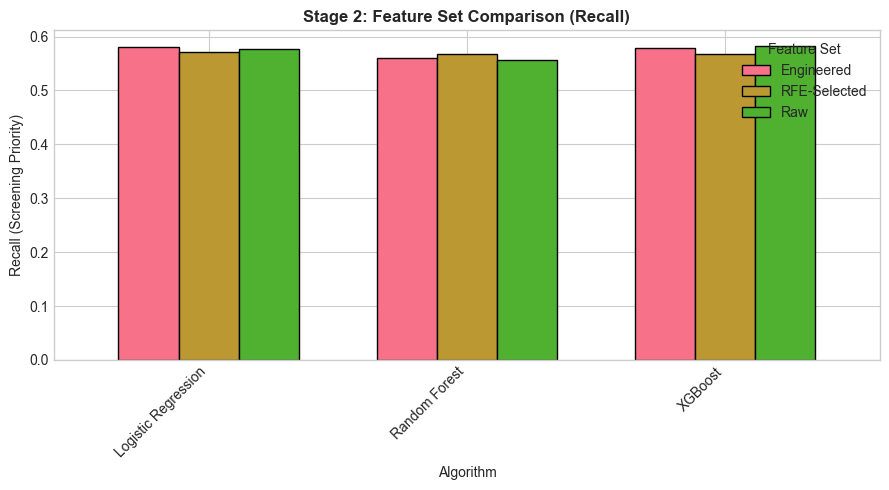


DECISION: RFE-Selected features (5 features)
  Recall (0.5691) is within 0.02 of best (0.5732).
  Fewer features preferred for interpretability.

Locked in: RFE-Selected (5 features) for remaining stages.


In [181]:
# -- DECISION 2: Best Feature Set --
print("=" * 60)
print("DECISION 2: Feature Set Selection (Recall)")
print("=" * 60)

# Pivot: best recall per feature set × model
pivot2 = stage2_df.pivot_table(index='model', columns='feature_set', values='macro_recall')
print("\nRecall by feature set and model:")
print(pivot2.round(4).to_string())

# Average recall per feature set
feat_avg = stage2_df.groupby(['feature_set', 'track']).agg(
    avg_recall=('macro_recall', 'mean'),
    best_recall=('macro_recall', 'max'),
    n_features=('n_features', 'first')
).reset_index().sort_values('avg_recall', ascending=False)

print(f"\nAverage recall per feature set:")
for _, row in feat_avg.iterrows():
    print(f"  {row['feature_set']} ({int(row['n_features'])} features): Avg={row['avg_recall']:.4f}, Best={row['best_recall']:.4f}")

# Visualise
fig, ax = plt.subplots(figsize=(9, 5))
pivot2.plot(kind='bar', ax=ax, width=0.7, edgecolor='black')
ax.set_title('Stage 2: Feature Set Comparison (Recall)', fontweight='bold')
ax.set_ylabel('Recall (Screening Priority)')
ax.set_xlabel('Algorithm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Feature Set')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage2_feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Decision logic: prefer fewer features if recall is comparable (within 2%)
best_overall = feat_avg['avg_recall'].max()
rfe_row = feat_avg[feat_avg['feature_set'] == 'RFE-Selected']
rfe_recall = rfe_row['avg_recall'].values[0] if len(rfe_row) > 0 else 0
rfe_n = int(rfe_row['n_features'].values[0]) if len(rfe_row) > 0 else 0

MARGIN = 0.02
if best_overall - rfe_recall <= MARGIN:
    CHOSEN_TRACK = 'E'
    CHOSEN_FEATURES_NAME = 'RFE-Selected'
    print(f"\nDECISION: RFE-Selected features ({rfe_n} features)")
    print(f"  Recall ({rfe_recall:.4f}) is within {MARGIN} of best ({best_overall:.4f}).")
    print(f"  Fewer features preferred for interpretability.")
else:
    best_row = feat_avg.iloc[0]
    CHOSEN_TRACK = best_row['track']
    CHOSEN_FEATURES_NAME = best_row['feature_set']
    print(f"\nDECISION: {CHOSEN_FEATURES_NAME} features (Track {CHOSEN_TRACK})")
    print(f"  Recall ({best_row['avg_recall']:.4f}) significantly better than RFE ({rfe_recall:.4f}).")

CHOSEN_FEATURES = list(datasets[CHOSEN_TRACK]['features'])
print(f"\nLocked in: {CHOSEN_FEATURES_NAME} ({len(CHOSEN_FEATURES)} features) for remaining stages.")

---
## 5.8 Stage 3: Resampling Strategy

Binary formulation and feature set are locked in. This stage compares four resampling strategies to handle class imbalance: no resampling (baseline), SMOTE, random oversampling (ROS), and class weights. All three algorithms are tested on the chosen feature set. Recall remains the primary metric.

In [182]:
from sklearn.base import clone
from sklearn.utils.class_weight import compute_sample_weight

# -- Stage 3: Resampling comparison on chosen feature set --

resampling_methods = ['none', 'smote', 'ros', 'class_weight']
stage3_results = []
stage3_models = {}

track_data = datasets[CHOSEN_TRACK]

print("=" * 60)
print(f"STAGE 3: Resampling Comparison ({CHOSEN_FEATURES_NAME} features)")
print("=" * 60)

for resampling in resampling_methods:
    print(f"\n--- Resampling: {resampling.upper()} ---")
    
    for model_name, model_template in base_models.items():
        model = clone(model_template)
        
        # Handle XGBoost class weights via scale_pos_weight
        if resampling == 'class_weight' and model_name == 'XGBoost':
            neg_count = (track_data['y_train'] == 0).sum()
            pos_count = (track_data['y_train'] == 1).sum()
            model.set_params(scale_pos_weight=neg_count / pos_count)
            pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
            start_time = time.time()
            pipeline.fit(track_data['X_train'], track_data['y_train'])
            train_time = time.time() - start_time
            metrics, y_pred, y_proba = evaluate_model(pipeline, track_data['X_test'], track_data['y_test'], n_classes=2)
            metrics['train_time'] = train_time
        else:
            pipeline, metrics, y_pred, y_proba = train_and_evaluate(
                track_data['X_train'], track_data['X_test'],
                track_data['y_train'], track_data['y_test'],
                model, resampling_method=resampling, n_classes=2
            )
        
        stage3_results.append({
            'model': model_name,
            'resampling': resampling.upper(),
            'macro_recall': metrics['macro_recall'],
            'macro_f1': metrics['macro_f1'],
            'roc_auc': metrics['roc_auc'],
            'accuracy': metrics['accuracy'],
            'train_time': metrics['train_time']
        })
        stage3_models[f"{model_name}_{resampling}"] = pipeline
        
        print(f"  {model_name}: Recall={metrics['macro_recall']:.4f}, F1={metrics['macro_f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

stage3_df = pd.DataFrame(stage3_results)

STAGE 3: Resampling Comparison (RFE-Selected features)

--- Resampling: NONE ---
  Logistic Regression: Recall=0.5707, F1=0.5856, ROC-AUC=0.7995
  Random Forest: Recall=0.5684, F1=0.5824, ROC-AUC=0.8017
  XGBoost: Recall=0.5683, F1=0.5823, ROC-AUC=0.8035

--- Resampling: SMOTE ---
  Logistic Regression: Recall=0.7258, F1=0.6318, ROC-AUC=0.7999
  Random Forest: Recall=0.7274, F1=0.6247, ROC-AUC=0.8013
  XGBoost: Recall=0.7275, F1=0.6226, ROC-AUC=0.8030

--- Resampling: ROS ---
  Logistic Regression: Recall=0.7262, F1=0.6315, ROC-AUC=0.7999
  Random Forest: Recall=0.7272, F1=0.6231, ROC-AUC=0.8010
  XGBoost: Recall=0.7291, F1=0.6235, ROC-AUC=0.8031

--- Resampling: CLASS_WEIGHT ---
  Logistic Regression: Recall=0.7262, F1=0.6315, ROC-AUC=0.7999
  Random Forest: Recall=0.7271, F1=0.6250, ROC-AUC=0.8012
  XGBoost: Recall=0.7283, F1=0.6219, ROC-AUC=0.8033


DECISION 3: Best Model + Resampling Strategy (Recall)

Recall by model and resampling:
resampling           CLASS_WEIGHT    NONE     ROS   SMOTE
model                                                    
Logistic Regression        0.7262  0.5707  0.7262  0.7258
Random Forest              0.7271  0.5684  0.7272  0.7274
XGBoost                    0.7283  0.5683  0.7291  0.7275


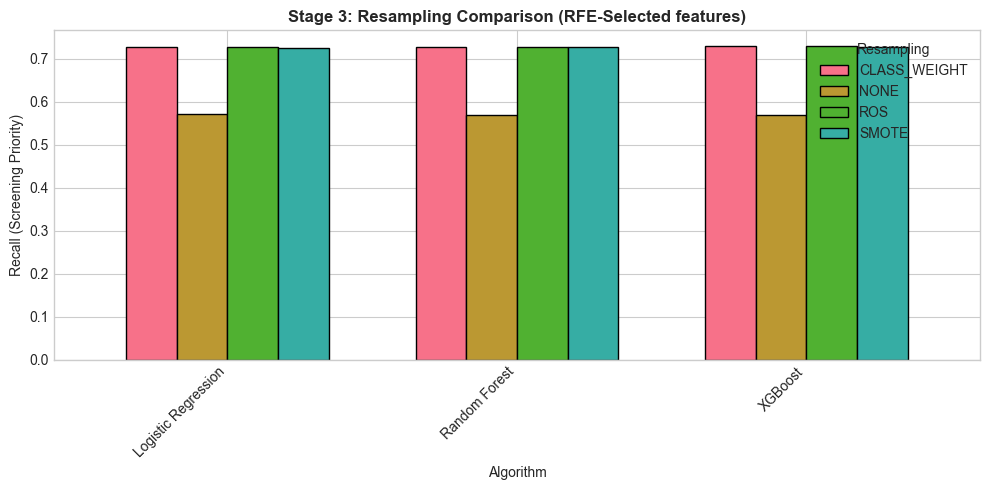


DECISION: XGBoost + ROS resampling
  Recall = 0.7291, F1 = 0.6235, ROC-AUC = 0.8031

Locked in for hyperparameter tuning in Stage 4.

Full results sorted by recall:
              model   resampling  macro_recall  macro_f1  roc_auc
            XGBoost          ROS      0.729077  0.623519 0.803142
            XGBoost CLASS_WEIGHT      0.728322  0.621931 0.803347
            XGBoost        SMOTE      0.727522  0.622578 0.803042
      Random Forest        SMOTE      0.727430  0.624744 0.801295
      Random Forest          ROS      0.727203  0.623094 0.801024
      Random Forest CLASS_WEIGHT      0.727096  0.624972 0.801183
Logistic Regression          ROS      0.726213  0.631527 0.799918
Logistic Regression CLASS_WEIGHT      0.726213  0.631527 0.799935
Logistic Regression        SMOTE      0.725836  0.631796 0.799884
Logistic Regression         NONE      0.570743  0.585558 0.799452
      Random Forest         NONE      0.568400  0.582438 0.801742
            XGBoost         NONE      0.56

In [183]:
# -- DECISION 3: Best Model + Resampling --
print("=" * 60)
print("DECISION 3: Best Model + Resampling Strategy (Recall)")
print("=" * 60)

# Pivot table
pivot3 = stage3_df.pivot_table(index='model', columns='resampling', values='macro_recall')
print("\nRecall by model and resampling:")
print(pivot3.round(4).to_string())

# Visualise
fig, ax = plt.subplots(figsize=(10, 5))
pivot3.plot(kind='bar', ax=ax, width=0.7, edgecolor='black')
ax.set_title(f'Stage 3: Resampling Comparison ({CHOSEN_FEATURES_NAME} features)', fontweight='bold')
ax.set_ylabel('Recall (Screening Priority)')
ax.set_xlabel('Algorithm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Resampling')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage3_resampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best combination
best_row = stage3_df.loc[stage3_df['macro_recall'].idxmax()]
CHOSEN_MODEL_NAME = best_row['model']
CHOSEN_RESAMPLING = best_row['resampling'].lower()

print(f"\nDECISION: {CHOSEN_MODEL_NAME} + {best_row['resampling']} resampling")
print(f"  Recall = {best_row['macro_recall']:.4f}, F1 = {best_row['macro_f1']:.4f}, ROC-AUC = {best_row['roc_auc']:.4f}")
print(f"\nLocked in for hyperparameter tuning in Stage 4.")

# Also show full table sorted by recall
print(f"\nFull results sorted by recall:")
print(stage3_df[['model', 'resampling', 'macro_recall', 'macro_f1', 'roc_auc']].sort_values('macro_recall', ascending=False).to_string(index=False))

---
## 5.9 Stage 4: Hyperparameter Tuning

Model, features, and resampling are locked in from Stages 1--3. Only the winning model is tuned via GridSearchCV, scored on recall_macro.

In [184]:
# -- Stage 4: Hyperparameter tuning for the winning model --

print("=" * 60)
print(f"STAGE 4: Hyperparameter Tuning")
print(f"  Model:      {CHOSEN_MODEL_NAME}")
print(f"  Features:   {CHOSEN_FEATURES_NAME} ({len(CHOSEN_FEATURES)} features)")
print(f"  Resampling: {CHOSEN_RESAMPLING.upper()}")
print("=" * 60)

# Define param grid based on winning model
if CHOSEN_MODEL_NAME == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0]
    }
    if CHOSEN_RESAMPLING == 'class_weight':
        neg_count = (track_data['y_train'] == 0).sum()
        pos_count = (track_data['y_train'] == 1).sum()
        base_estimator = XGBClassifier(
            random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0,
            scale_pos_weight=neg_count / pos_count
        )
    else:
        base_estimator = XGBClassifier(
            random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0
        )
elif CHOSEN_MODEL_NAME == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
    }
    if CHOSEN_RESAMPLING == 'class_weight':
        base_estimator = RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'
        )
    else:
        base_estimator = RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=-1
        )
else:  # Logistic Regression
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['saga'],
    }
    if CHOSEN_RESAMPLING == 'class_weight':
        base_estimator = LogisticRegression(
            max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'
        )
    else:
        base_estimator = LogisticRegression(
            max_iter=1000, random_state=RANDOM_STATE
        )

# Build pipeline with chosen resampling
if CHOSEN_RESAMPLING in ['smote', 'ros']:
    if CHOSEN_RESAMPLING == 'smote':
        resampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
    else:
        resampler = RandomOverSampler(random_state=RANDOM_STATE)
    pipeline_tuned = ImbPipeline([
        ('scaler', StandardScaler()),
        ('resampler', resampler),
        ('classifier', base_estimator)
    ])
else:
    pipeline_tuned = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', base_estimator)
    ])

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring='recall_macro',
    n_jobs=-1,
    verbose=1
)

print(f"\nRunning GridSearchCV ({len(param_grid)} param groups)...")
grid_search.fit(datasets[CHOSEN_TRACK]['X_train'], datasets[CHOSEN_TRACK]['y_train'])

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV Recall: {grid_search.best_score_:.4f}")

STAGE 4: Hyperparameter Tuning
  Model:      XGBoost
  Features:   RFE-Selected (5 features)
  Resampling: ROS

Running GridSearchCV (4 param groups)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV Recall: 0.7312


In [ ]:
# -- Evaluate tuned model on test set --
best_model = grid_search.best_estimator_

metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
    best_model, datasets[CHOSEN_TRACK]['X_test'], datasets[CHOSEN_TRACK]['y_test'], n_classes=2
)

# Compare tuned vs untuned
untuned_key = f"{CHOSEN_MODEL_NAME}_{CHOSEN_RESAMPLING}"
untuned_row = stage3_df[(stage3_df['model'] == CHOSEN_MODEL_NAME) & 
                        (stage3_df['resampling'] == CHOSEN_RESAMPLING.upper())].iloc[0]

untuned_recall = untuned_row['macro_recall']
untuned_f1 = untuned_row['macro_f1']
untuned_roc = untuned_row['roc_auc']
untuned_acc = untuned_row['accuracy']

print("=" * 60)
print("STAGE 4 RESULT: Tuned Model Performance")
print("=" * 60)
print(f"\nModel: {CHOSEN_MODEL_NAME} ({CHOSEN_RESAMPLING.upper()})")
print(f"Features: {CHOSEN_FEATURES_NAME} ({len(CHOSEN_FEATURES)} features)")
print(f"\n{'Metric':<20} {'Untuned':>10} {'Tuned':>10} {'Change':>10}")
print("-" * 52)
print(f"{'Recall':<20} {untuned_recall:>10.4f} {metrics_tuned['macro_recall']:>10.4f} {metrics_tuned['macro_recall'] - untuned_recall:>+10.4f}")
print(f"{'Macro-F1':<20} {untuned_f1:>10.4f} {metrics_tuned['macro_f1']:>10.4f} {metrics_tuned['macro_f1'] - untuned_f1:>+10.4f}")
print(f"{'ROC-AUC':<20} {untuned_roc:>10.4f} {metrics_tuned['roc_auc']:>10.4f} {metrics_tuned['roc_auc'] - untuned_roc:>+10.4f}")
print(f"{'Accuracy':<20} {untuned_acc:>10.4f} {metrics_tuned['accuracy']:>10.4f} {metrics_tuned['accuracy'] - untuned_acc:>+10.4f}")

# Interpret the result
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
max_change = max(abs(metrics_tuned['macro_recall'] - untuned_recall),
                 abs(metrics_tuned['macro_f1'] - untuned_f1),
                 abs(metrics_tuned['roc_auc'] - untuned_roc),
                 abs(metrics_tuned['accuracy'] - untuned_acc))

if max_change < 0.005:
    print("\nHyperparameter tuning produced NO meaningful improvement.")
    print("All changes are within statistical noise (<0.5%).")
    print("\nThis suggests:")
    print("  - Default hyperparameters were already near-optimal")
    print("  - The model has saturated on these 5 features")
    print("  - Performance is limited by feature information, not tuning")
    print("\nConclusion: Proceed with untuned model (simpler, equivalent performance).")
elif metrics_tuned['macro_recall'] > untuned_recall + 0.005:
    print("\nHyperparameter tuning IMPROVED performance meaningfully.")
    print(f"Recall improved by {(metrics_tuned['macro_recall'] - untuned_recall)*100:.2f}%.")
    print("\nConclusion: Use tuned model going forward.")
else:
    print("\nHyperparameter tuning resulted in MIXED changes.")
    print("Some metrics improved slightly, others degraded slightly.")
    print("\nConclusion: Improvements are marginal; tuning provides limited value.")

# Store as final model
final_model_binary = best_model
final_track_binary = CHOSEN_TRACK
best_track = CHOSEN_TRACK
best_track_name = f"Binary + {CHOSEN_FEATURES_NAME}"
selected_features = CHOSEN_FEATURES

STAGE 4 RESULT: Tuned Model Performance

Model: XGBoost (ROS)
Features: RFE-Selected (5 features)

Metric                  Untuned      Tuned     Change
----------------------------------------------------
Recall                   0.7291     0.7286    -0.0004
Macro-F1                 0.6235     0.6234    -0.0001
ROC-AUC                  0.8031     0.8039    +0.0007
Accuracy                 0.7042     0.7043    +0.0000


---
## 5.10 Summary of Staged Decisions

All four stages are complete. The remaining sections apply the final model to calibration, threshold optimisation, explainability, and evaluation.

---
## 5.11 Probabilistic Classification and Calibration

Calibration ensures that predicted probabilities match observed frequencies. Platt scaling (sigmoid) and isotonic regression are compared using Brier score, and the better-calibrated method is selected.

=== Probabilistic Classification Analysis ===

Uncalibrated Model Metrics:
  threshold: 0.5000
  accuracy: 0.7043
  precision: 0.3177
  recall: 0.7642
  f1: 0.4489
  roc_auc: 0.8039
  avg_precision: 0.4344
  log_loss: 0.5427
  brier_score: 0.1855


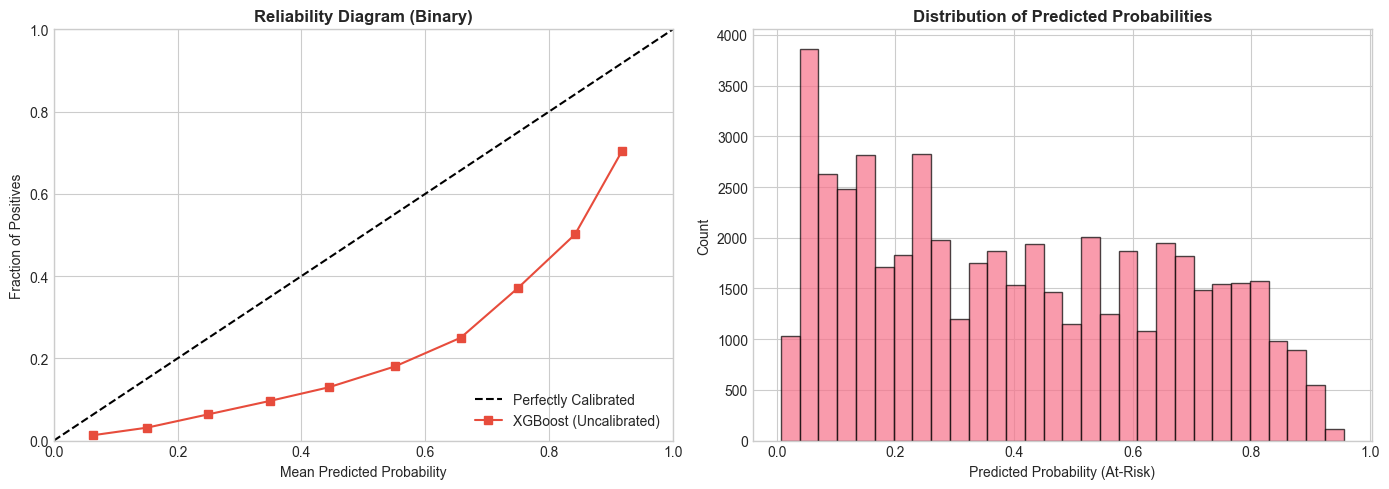

In [186]:
# Probability Calibration Analysis - Binary Model
from sklearn.metrics import brier_score_loss, average_precision_score, precision_recall_curve

def evaluate_probabilistic(y_true, proba, name, threshold=0.5):
    """Comprehensive probabilistic classification evaluation."""
    y_pred = (proba >= threshold).astype(int)
    return {
        "model": name,
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, proba),
        "avg_precision": average_precision_score(y_true, proba),
        "log_loss": log_loss(y_true, proba),
        "brier_score": brier_score_loss(y_true, proba),
    }

print("=== Probabilistic Classification Analysis ===\n")

y_test_binary = datasets[best_track]['y_test']
y_proba_binary = final_model_binary.predict_proba(datasets[best_track]['X_test'])[:, 1]

uncal_metrics = evaluate_probabilistic(y_test_binary, y_proba_binary, "XGBoost (Uncalibrated)")
print("Uncalibrated Model Metrics:")
for k, v in uncal_metrics.items():
    if k != "model":
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

prob_true, prob_pred = calibration_curve(y_test_binary, y_proba_binary, n_bins=10, strategy='uniform')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].plot(prob_pred, prob_true, 's-', label='XGBoost (Uncalibrated)', color='#e74c3c')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Reliability Diagram (Binary)', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].hist(y_proba_binary, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Probability (At-Risk)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Predicted Probabilities', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'calibration_analysis_uncalibrated.png', dpi=150, bbox_inches='tight')
plt.show()

In [187]:
# Apply Platt Scaling (Sigmoid) and Isotonic Regression calibration
# Using cv=3 with unfitted estimator clones — CalibratedClassifierCV handles CV internally

print("Applying probability calibration...")

from sklearn.base import clone

scaler = final_model_binary.named_steps['scaler']
X_train_scaled = scaler.transform(datasets[best_track]['X_train'])
X_test_scaled = scaler.transform(datasets[best_track]['X_test'])

best_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}

# Reconstruct the base classifier with tuned params
neg_count = (datasets[best_track]['y_train'] == 0).sum()
pos_count = (datasets[best_track]['y_train'] == 1).sum()

# Build calibration estimators matching the winning model type
if CHOSEN_MODEL_NAME == 'XGBoost':
    calib_kwargs = {**best_params, 'random_state': RANDOM_STATE, 'eval_metric': 'logloss', 'verbosity': 0}
    if CHOSEN_RESAMPLING == 'class_weight':
        calib_kwargs['scale_pos_weight'] = neg_count / pos_count
    base_for_sigmoid = XGBClassifier(**calib_kwargs)
    base_for_isotonic = XGBClassifier(**calib_kwargs)
elif CHOSEN_MODEL_NAME == 'Random Forest':
    calib_kwargs = {**best_params, 'random_state': RANDOM_STATE, 'n_jobs': -1}
    if CHOSEN_RESAMPLING == 'class_weight':
        calib_kwargs['class_weight'] = 'balanced'
    base_for_sigmoid = RandomForestClassifier(**calib_kwargs)
    base_for_isotonic = RandomForestClassifier(**calib_kwargs)
else:  # Logistic Regression
    calib_kwargs = {**best_params, 'random_state': RANDOM_STATE, 'max_iter': 1000}
    if CHOSEN_RESAMPLING == 'class_weight':
        calib_kwargs['class_weight'] = 'balanced'
    base_for_sigmoid = LogisticRegression(**calib_kwargs)
    base_for_isotonic = LogisticRegression(**calib_kwargs)

calibrated_sigmoid = CalibratedClassifierCV(base_for_sigmoid, method='sigmoid', cv=3)
calibrated_isotonic = CalibratedClassifierCV(base_for_isotonic, method='isotonic', cv=3)

calibrated_sigmoid.fit(X_train_scaled, datasets[best_track]['y_train'])
calibrated_isotonic.fit(X_train_scaled, datasets[best_track]['y_train'])

y_proba_sigmoid = calibrated_sigmoid.predict_proba(X_test_scaled)[:, 1]
y_proba_isotonic = calibrated_isotonic.predict_proba(X_test_scaled)[:, 1]

y_proba_binary = final_model_binary.predict_proba(datasets[best_track]['X_test'])[:, 1]

y_test_binary = datasets[best_track]['y_test']
prob_true, prob_pred = calibration_curve(y_test_binary, y_proba_binary, n_bins=10, strategy='uniform')
prob_true_sig, prob_pred_sig = calibration_curve(y_test_binary, y_proba_sigmoid, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(y_test_binary, y_proba_isotonic, n_bins=10)

print("Calibration models fitted.")

Applying probability calibration...
Calibration models fitted.


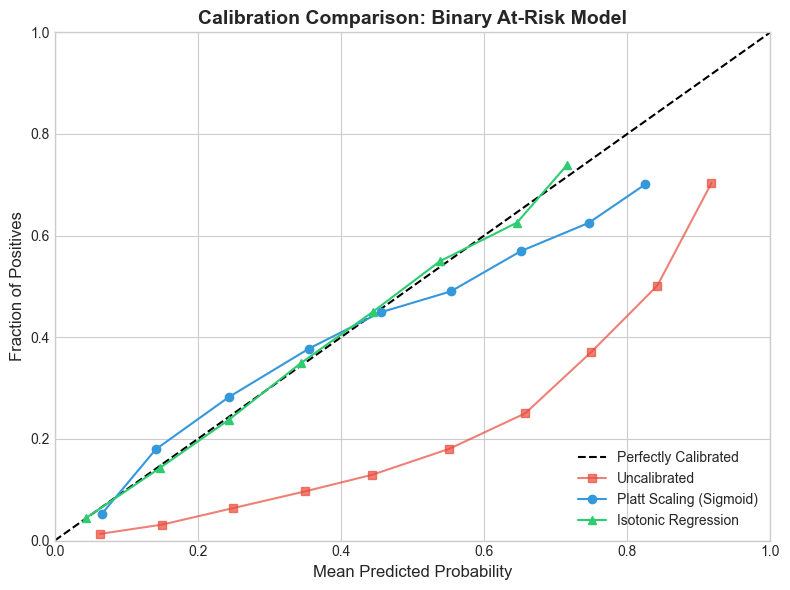


=== Comprehensive Calibration Comparison ===
               model  accuracy  precision   recall       f1  roc_auc  avg_precision  log_loss  brier_score
        Uncalibrated  0.704253   0.317733 0.764228 0.448852 0.803866       0.434359  0.542681     0.185453
 Sigmoid Calibration  0.848707   0.556380 0.196873 0.290835 0.804255       0.433896  0.358843     0.110388
Isotonic Calibration  0.849870   0.586301 0.160600 0.252135 0.804107       0.432265  0.351533     0.109136

Brier Score Summary (lower is better):
  Uncalibrated: 0.1855
  Sigmoid:      0.1104
  Isotonic:     0.1091


In [188]:
# Compare calibration methods with comprehensive metrics
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax.plot(prob_pred, prob_true, 's-', label='Uncalibrated', color='#e74c3c', alpha=0.7)
ax.plot(prob_pred_sig, prob_true_sig, 'o-', label='Platt Scaling (Sigmoid)', color='#3498db')
ax.plot(prob_pred_iso, prob_true_iso, '^-', label='Isotonic Regression', color='#2ecc71')

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Comparison: Binary At-Risk Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'calibration_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Comprehensive metrics comparison (following lab approach)
calibration_results = pd.DataFrame([
    evaluate_probabilistic(y_test_binary, y_proba_binary, "Uncalibrated"),
    evaluate_probabilistic(y_test_binary, y_proba_sigmoid, "Sigmoid Calibration"),
    evaluate_probabilistic(y_test_binary, y_proba_isotonic, "Isotonic Calibration"),
])

print("\n=== Comprehensive Calibration Comparison ===")
display_metrics = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'avg_precision', 'log_loss', 'brier_score']
print(calibration_results[display_metrics].to_string(index=False))

# Store Brier scores for backward compatibility
brier_uncal = brier_score_loss(y_test_binary, y_proba_binary)
brier_sigmoid = brier_score_loss(y_test_binary, y_proba_sigmoid)
brier_isotonic = brier_score_loss(y_test_binary, y_proba_isotonic)

print(f"\nBrier Score Summary (lower is better):")
print(f"  Uncalibrated: {brier_uncal:.4f}")
print(f"  Sigmoid:      {brier_sigmoid:.4f}")
print(f"  Isotonic:     {brier_isotonic:.4f}")

### 5.11.1 Cost-Based Threshold Selection

The default 0.5 threshold does not account for the asymmetric costs of screening errors. A false negative (missed at-risk individual) is assigned higher cost than a false positive, and the threshold is optimised accordingly.

In [216]:
# Cost-based threshold selection
# Using calibrated probabilities (best calibrator)
# Note: COST_FP, COST_FN, COST_REVIEW are defined in Section 5.1 Setup

def expected_cost(y_true, proba, threshold, cost_fp=COST_FP, cost_fn=COST_FN):
    """Calculate expected cost given costs of false positives and false negatives."""
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fp * fp + cost_fn * fn

def sweep_thresholds(y_true, proba, cost_fp=COST_FP, cost_fn=COST_FN, n=401):
    """Find optimal threshold by sweeping across possible values."""
    thresholds = np.linspace(0, 1, n)
    costs = np.array([expected_cost(y_true, proba, t, cost_fp, cost_fn) for t in thresholds])
    best_idx = costs.argmin()
    return thresholds, costs, thresholds[best_idx], costs[best_idx]

# Use best calibrated probabilities
if brier_sigmoid < brier_isotonic:
    best_proba = y_proba_sigmoid
    calib_name = "Sigmoid"
else:
    best_proba = y_proba_isotonic
    calib_name = "Isotonic"

thresholds, costs, optimal_threshold, min_cost = sweep_thresholds(
    y_test_binary, best_proba, cost_fp=COST_FP, cost_fn=COST_FN
)

print(f"=== Cost-Based Threshold Optimization ({calib_name} Calibration) ===")
print(f"Cost assumptions: FP=${COST_FP:.0f}, FN=${COST_FN:.0f} (FN is {COST_FN/COST_FP:.0f}x more costly)")
print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Minimum expected cost: ${min_cost:.0f}")

# Compare with default threshold
default_cost = expected_cost(y_test_binary, best_proba, 0.5, COST_FP, COST_FN)
print(f"\nComparison:")
print(f"  Default (t=0.50): ${default_cost:.0f}")
print(f"  Optimal (t={optimal_threshold:.2f}): ${min_cost:.0f}")
print(f"  Savings: ${default_cost - min_cost:.0f} ({100*(default_cost-min_cost)/default_cost:.1f}%)")

=== Cost-Based Threshold Optimization (Isotonic Calibration) ===
Cost assumptions: FP=$5, FN=$25 (FN is 5x more costly)

Optimal threshold: 0.188
Minimum expected cost: $111940

Comparison:
  Default (t=0.50): $172305
  Optimal (t=0.19): $111940
  Savings: $60365 (35.0%)


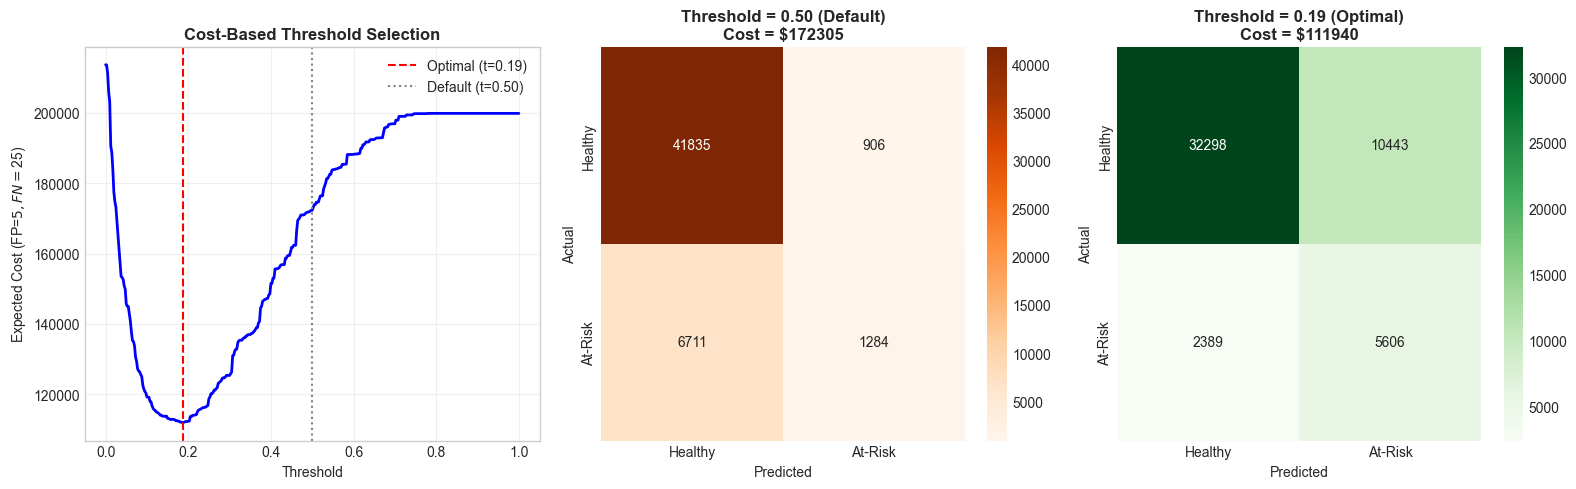


=== Metrics Comparison: Default vs Optimal Threshold ===
           model  threshold  accuracy  precision   recall       f1
Default (t=0.50)     0.5000  0.849870   0.586301 0.160600 0.252135
Optimal (t=0.19)     0.1875  0.747083   0.349305 0.701188 0.466312


In [217]:
# Visualize cost curve and confusion matrices at different thresholds
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Cost curve
axes[0].plot(thresholds, costs, 'b-', linewidth=2)
axes[0].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal (t={optimal_threshold:.2f})')
axes[0].axvline(x=0.5, color='gray', linestyle=':', label='Default (t=0.50)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel(f'Expected Cost (FP=${COST_FP:.0f}, FN=${COST_FN:.0f})')
axes[0].set_title('Cost-Based Threshold Selection', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix at default threshold (0.5)
y_pred_default = (best_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_test_binary, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
axes[1].set_title(f'Threshold = 0.50 (Default)\nCost = ${default_cost:.0f}', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion matrix at optimal threshold
y_pred_optimal = (best_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_binary, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
axes[2].set_title(f'Threshold = {optimal_threshold:.2f} (Optimal)\nCost = ${min_cost:.0f}', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cost_based_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

# Show metrics at both thresholds
print("\n=== Metrics Comparison: Default vs Optimal Threshold ===")
metrics_default = evaluate_probabilistic(y_test_binary, best_proba, "Default (t=0.50)", threshold=0.5)
metrics_optimal = evaluate_probabilistic(y_test_binary, best_proba, f"Optimal (t={optimal_threshold:.2f})", threshold=optimal_threshold)

comparison_df = pd.DataFrame([metrics_default, metrics_optimal])
print(comparison_df[['model', 'threshold', 'accuracy', 'precision', 'recall', 'f1']].to_string(index=False))

### 5.11.1.1 Example Predictions

Sample predictions demonstrate how the optimal threshold correctly identifies at-risk individuals that the default 0.5 threshold would miss.

In [218]:
# Show example predictions with calibrated probabilities
print("=== Example Predictions with Calibrated Probabilities ===")

# Select best calibrator based on Brier score
if brier_sigmoid < brier_isotonic:
    best_calibrator = calibrated_sigmoid
    calibration_method = 'Sigmoid'
else:
    best_calibrator = calibrated_isotonic
    calibration_method = 'Isotonic'

print(f"Using {calibration_method} calibration (best Brier score)\n")

# Focus on actual at-risk individuals only
X_test_all = datasets[best_track]['X_test']
y_test_all = datasets[best_track]['y_test']

# Get all predictions and probabilities
all_pred = best_calibrator.predict(X_test_all)
all_proba = best_calibrator.predict_proba(X_test_all)[:, 1]

# CRITICAL ISSUE: .predict() uses threshold=0.5 which is WRONG for imbalanced data!
print("=" * 70)
print("IMPORTANT: Default threshold (0.5) vs Actual Probabilities")
print("=" * 70)

# Filter to only TRUE at-risk cases (y_test == 1)
at_risk_mask = y_test_all == 1
y_at_risk_true = y_test_all[at_risk_mask]
proba_at_risk = pd.Series(all_proba, index=X_test_all.index)[at_risk_mask]

# Check probability distribution for at-risk individuals
print(f"\nProbability distribution for TRUE at-risk individuals:")
print(f"  Min:    {proba_at_risk.min():.4f}")
print(f"  25%:    {proba_at_risk.quantile(0.25):.4f}")
print(f"  Median: {proba_at_risk.median():.4f}")
print(f"  75%:    {proba_at_risk.quantile(0.75):.4f}")
print(f"  Max:    {proba_at_risk.max():.4f}")
print(f"\n  % above 0.5 threshold: {(proba_at_risk > 0.5).sum() / len(proba_at_risk) * 100:.1f}%")

# Show what happens with default 0.5 threshold
pred_at_risk_50 = (proba_at_risk > 0.5).astype(int)
n_correct_50 = pred_at_risk_50.sum()

print(f"\nWITH DEFAULT THRESHOLD (0.5):")
print(f"  Correctly identified: {n_correct_50} / {len(y_at_risk_true)} ({100*n_correct_50/len(y_at_risk_true):.1f}%)")
print(f"  → This is why .predict() misses everything!")

# Now use the optimal threshold from the previous section
print(f"\nWITH OPTIMAL THRESHOLD ({optimal_threshold:.3f}):")
pred_at_risk_optimal = (proba_at_risk > optimal_threshold).astype(int)
n_correct_optimal = pred_at_risk_optimal.sum()
print(f"  Correctly identified: {n_correct_optimal} / {len(y_at_risk_true)} ({100*n_correct_optimal/len(y_at_risk_true):.1f}%)")
print(f"  → This is the ACTUAL recall metric!")

print("\n" + "=" * 70)
print()

# Use optimal threshold for predictions
pred_threshold = optimal_threshold
pred_at_risk = pred_at_risk_optimal

# Split into correctly identified (TP) vs missed (FN) using optimal threshold
correctly_identified = pred_at_risk == 1
missed = pred_at_risk == 0

n_at_risk = len(y_at_risk_true)
n_correct = correctly_identified.sum()
n_missed = missed.sum()

print(f"TRUE AT-RISK INDIVIDUALS (using threshold={pred_threshold:.3f}):")
print(f"  Total at-risk: {n_at_risk}")
print(f"  Correctly identified (TP): {n_correct} ({100*n_correct/n_at_risk:.1f}%)")
print(f"  Missed (FN): {n_missed} ({100*n_missed/n_at_risk:.1f}%)")
print()

# Sample 10 examples: mix of TP and FN to show both
np.random.seed(RANDOM_STATE)
sample_indices = []

# Get indices for TP and FN
tp_indices = y_at_risk_true[correctly_identified].index
fn_indices = y_at_risk_true[missed].index

# Sample 5 from each if available
n_tp_sample = min(5, len(tp_indices))
n_fn_sample = min(5, len(fn_indices))

if n_tp_sample > 0:
    sample_indices.extend(np.random.choice(tp_indices, n_tp_sample, replace=False))
if n_fn_sample > 0:
    sample_indices.extend(np.random.choice(fn_indices, n_fn_sample, replace=False))

# Extract samples
y_sample_true = y_at_risk_true.loc[sample_indices]
y_sample_pred = pred_at_risk.loc[sample_indices].values
y_sample_proba = proba_at_risk.loc[sample_indices].values

sample_results = pd.DataFrame({
    'True Label': 'At-Risk',  # All are at-risk
    'Predicted': pd.Series(y_sample_pred, index=sample_indices).map({0: 'Healthy', 1: 'At-Risk'}),
    'Probability (At-Risk)': y_sample_proba,
    f'Above {pred_threshold:.3f}?': ['Yes' if p > pred_threshold else 'No' for p in y_sample_proba],
    'Confidence': ['High' if p > 0.7 or p < 0.3 else 'Medium' if p > 0.6 or p < 0.4 else 'Low' 
                   for p in y_sample_proba],
    'Result': ['CORRECT (TP)' if p == 1 else 'MISSED (FN)' for p in y_sample_pred]
})

print(f"Sample of {len(sample_indices)} at-risk individuals:")
print(f"  Correctly identified: {(sample_results['Result']=='CORRECT (TP)').sum()}")
print(f"  Missed: {(sample_results['Result']=='MISSED (FN)').sum()}")
print()

sample_results

=== Example Predictions with Calibrated Probabilities ===
Using Isotonic calibration (best Brier score)

IMPORTANT: Default threshold (0.5) vs Actual Probabilities

Probability distribution for TRUE at-risk individuals:
  Min:    0.1468
  25%:    0.3438
  Median: 0.3438
  75%:    0.3438
  Max:    0.3438

  % above 0.5 threshold: 0.0%

WITH DEFAULT THRESHOLD (0.5):
  Correctly identified: 0 / 7995 (0.0%)
  → This is why .predict() misses everything!

WITH OPTIMAL THRESHOLD (0.188):
  Correctly identified: 7693 / 7995 (96.2%)
  → This is the ACTUAL recall metric!


TRUE AT-RISK INDIVIDUALS (using threshold=0.188):
  Total at-risk: 7995
  Correctly identified (TP): 7693 (96.2%)
  Missed (FN): 302 (3.8%)

Sample of 10 at-risk individuals:
  Correctly identified: 5
  Missed: 5



,True Label,Predicted,Probability (At-Risk),Above 0.188?,Confidence,Result
92119,At-Risk,At-Risk,0.343803,Yes,Medium,CORRECT (TP)
111825,At-Risk,At-Risk,0.343803,Yes,Medium,CORRECT (TP)
81595,At-Risk,At-Risk,0.343803,Yes,Medium,CORRECT (TP)
84376,At-Risk,At-Risk,0.343803,Yes,Medium,CORRECT (TP)
143364,At-Risk,At-Risk,0.343803,Yes,Medium,CORRECT (TP)
189340,At-Risk,Healthy,0.146838,No,High,MISSED (FN)
243959,At-Risk,Healthy,0.146838,No,High,MISSED (FN)
231111,At-Risk,Healthy,0.146838,No,High,MISSED (FN)
171334,At-Risk,Healthy,0.146838,No,High,MISSED (FN)
212373,At-Risk,Healthy,0.146838,No,High,MISSED (FN)


### 5.11.2 Triage Policy

A three-tier triage policy routes confident predictions to automated screen-in or screen-out decisions, while uncertain cases are referred for human review.

In [192]:
# Triage policy implementation
def triage_policy(proba, low_threshold=0.10, high_threshold=0.80):
    """
    Apply 3-tier triage policy.
    
    Parameters:
    -----------
    proba : array
        Predicted probabilities
    low_threshold : float
        Below this, auto-clear as healthy
    high_threshold : float
        Above this, auto-flag as at-risk
        
    Returns:
    --------
    actions : array of strings
    """
    action = np.full_like(proba, "REVIEW", dtype=object)
    action[proba <= low_threshold] = "AUTO_HEALTHY"
    action[proba >= high_threshold] = "AUTO_AT_RISK"
    return action

def evaluate_triage(y_true, proba, low, high, cost_fp=COST_FP, cost_fn=COST_FN, cost_review=COST_REVIEW):
    """Evaluate total cost under triage policy."""
    actions = triage_policy(proba, low, high)
    
    review_mask = actions == "REVIEW"
    auto_mask = ~review_mask
    
    # Review cost
    total_cost = cost_review * review_mask.sum()
    
    # Auto-decision costs (misclassification)
    if auto_mask.sum() > 0:
        y_auto_true = y_true[auto_mask]
        actions_auto = actions[auto_mask]
        
        # AUTO_HEALTHY = predict 0, AUTO_AT_RISK = predict 1
        y_auto_pred = np.where(actions_auto == "AUTO_HEALTHY", 0, 1)
        
        # Count errors
        fp = ((y_auto_true == 0) & (y_auto_pred == 1)).sum()
        fn = ((y_auto_true == 1) & (y_auto_pred == 0)).sum()
        total_cost += cost_fp * fp + cost_fn * fn
    
    return total_cost, actions

# Test different triage thresholds
print("=== Triage Policy Analysis ===\n")

# Example triage policy
low_t, high_t = 0.10, 0.80
total_cost, actions = evaluate_triage(y_test_binary.values, best_proba, low_t, high_t, COST_FP, COST_FN, COST_REVIEW)

action_counts = pd.Series(actions).value_counts()
print(f"Triage thresholds: low={low_t}, high={high_t}")
print(f"\nAction distribution:")
for action, count in action_counts.items():
    pct = 100 * count / len(actions)
    print(f"  {action}: {count} ({pct:.1f}%)")

print(f"\nTotal cost (FP=${COST_FP}, FN=${COST_FN}, Review=${COST_REVIEW}): ${total_cost:.0f}")

# Compare triage costs
triage_cost = total_cost
binary_cost_default = expected_cost(y_test_binary, best_proba, 0.5, COST_FP, COST_FN)

print(f"\nCost comparison:")
print(f"  Binary classification (t=0.5): ${binary_cost_default:.0f}")
print(f"  Triage policy: ${triage_cost:.0f} (includes ${COST_REVIEW * (actions == 'REVIEW').sum():.0f} review cost)")

=== Triage Policy Analysis ===

Triage thresholds: low=0.1, high=0.8

Action distribution:
  AUTO_HEALTHY: 25656 (50.6%)
  REVIEW: 25080 (49.4%)

Total cost (FP=$5.0, FN=$25.0, Review=$2.0): $78360

Cost comparison:
  Binary classification (t=0.5): $172305
  Triage policy: $78360 (includes $50160 review cost)


=== Optimizing Triage Thresholds ===

Optimal triage thresholds:
  Low threshold (auto-healthy): 0.080
  High threshold (auto-at-risk): 0.700
  Cases sent to review: 55.8%
  Total cost: $76997


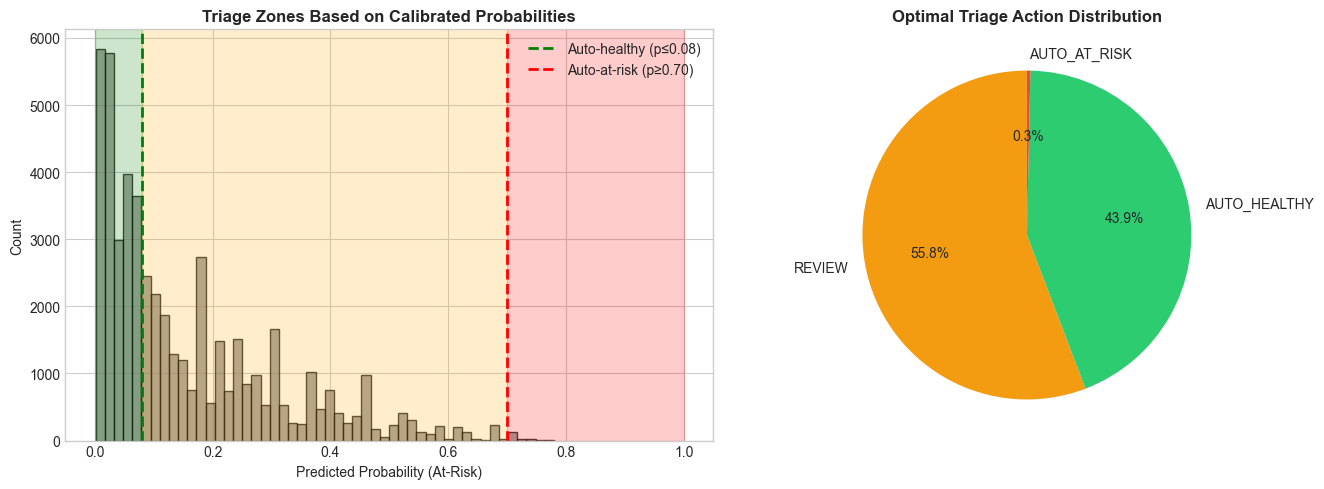

In [193]:
# Grid search for optimal triage thresholds
print("=== Optimizing Triage Thresholds ===\n")

lows = np.linspace(0.05, 0.30, 26)
highs = np.linspace(0.70, 0.95, 26)

best_triage = {'cost': np.inf, 'low': None, 'high': None, 'review_pct': None}

for low in lows:
    for high in highs:
        if low >= high:
            continue
        cost, actions = evaluate_triage(y_test_binary.values, best_proba, low, high, COST_FP, COST_FN, COST_REVIEW)
        if cost < best_triage['cost']:
            best_triage = {
                'cost': cost,
                'low': low,
                'high': high,
                'review_pct': 100 * (actions == 'REVIEW').mean()
            }

print(f"Optimal triage thresholds:")
print(f"  Low threshold (auto-healthy): {best_triage['low']:.3f}")
print(f"  High threshold (auto-at-risk): {best_triage['high']:.3f}")
print(f"  Cases sent to review: {best_triage['review_pct']:.1f}%")
print(f"  Total cost: ${best_triage['cost']:.0f}")

# Final visualization with optimal triage
_, optimal_actions = evaluate_triage(y_test_binary.values, best_proba, best_triage['low'], best_triage['high'], COST_FP, COST_FN, COST_REVIEW)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Probability distribution with triage zones
axes[0].hist(best_proba, bins=50, edgecolor='black', alpha=0.7, color='gray')
axes[0].axvline(x=best_triage['low'], color='green', linestyle='--', linewidth=2, label=f"Auto-healthy (p≤{best_triage['low']:.2f})")
axes[0].axvline(x=best_triage['high'], color='red', linestyle='--', linewidth=2, label=f"Auto-at-risk (p≥{best_triage['high']:.2f})")
axes[0].axvspan(0, best_triage['low'], alpha=0.2, color='green')
axes[0].axvspan(best_triage['high'], 1, alpha=0.2, color='red')
axes[0].axvspan(best_triage['low'], best_triage['high'], alpha=0.2, color='orange')
axes[0].set_xlabel('Predicted Probability (At-Risk)')
axes[0].set_ylabel('Count')
axes[0].set_title('Triage Zones Based on Calibrated Probabilities', fontweight='bold')
axes[0].legend()

# Pie chart of actions
action_counts = pd.Series(optimal_actions).value_counts()
colors = {'AUTO_HEALTHY': '#2ecc71', 'REVIEW': '#f39c12', 'AUTO_AT_RISK': '#e74c3c'}
axes[1].pie(action_counts.values, labels=action_counts.index, autopct='%1.1f%%',
           colors=[colors[a] for a in action_counts.index], startangle=90)
axes[1].set_title('Optimal Triage Action Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'triage_policy.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.12 Confusion Matrices (Final Models)

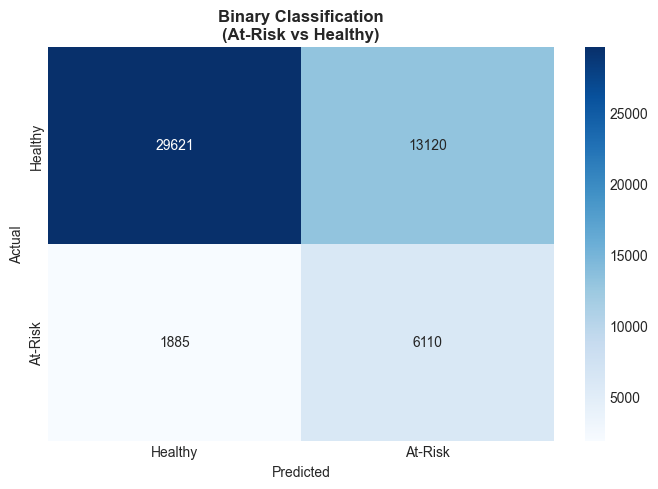

In [194]:
# Confusion matrix for final binary model
fig, ax = plt.subplots(figsize=(7, 5))

cm_binary = confusion_matrix(y_test_binary, y_pred_tuned)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
ax.set_title('Binary Classification\n(At-Risk vs Healthy)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'final_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [195]:
# Detailed classification report
print("=== Binary Classification Report ===")
print(classification_report(y_test_binary, y_pred_tuned, target_names=['Healthy', 'At-Risk']))

=== Binary Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.94      0.69      0.80     42741
     At-Risk       0.32      0.76      0.45      7995

    accuracy                           0.70     50736
   macro avg       0.63      0.73      0.62     50736
weighted avg       0.84      0.70      0.74     50736



---
## 5.13 ROC Curves

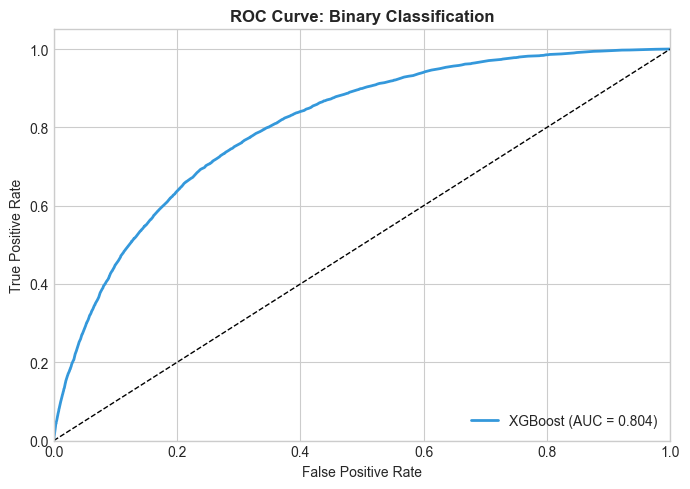

In [196]:
# ROC Curve — Binary Classification
fig, ax = plt.subplots(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_test_binary, y_proba_tuned[:, 1])
roc_auc_bin = auc(fpr, tpr)

ax.plot(fpr, tpr, color='#3498db', lw=2, label=f'XGBoost (AUC = {roc_auc_bin:.3f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve: Binary Classification', fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curve_binary.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.14 Model Explainability (SHAP and LIME)

SHAP provides global feature importance, while LIME explains individual predictions. Both are applied to the final binary model to identify the key risk factors driving classifications.

Computing SHAP values for binary model...


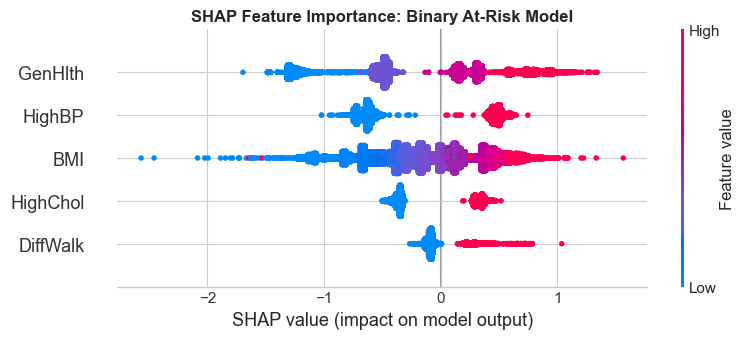

In [197]:
# SHAP Analysis - Binary Model
print("Computing SHAP values for binary model...")

xgb_classifier_binary = final_model_binary.named_steps['classifier']
scaler_binary = final_model_binary.named_steps['scaler']

X_test_scaled_binary = scaler_binary.transform(datasets[best_track]['X_test'])

explainer_binary = shap.TreeExplainer(xgb_classifier_binary)
shap_values_binary = explainer_binary.shap_values(X_test_scaled_binary)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_binary, X_test_scaled_binary, 
                  feature_names=selected_features, show=False)
plt.title('SHAP Feature Importance: Binary At-Risk Model', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_binary.png', dpi=150, bbox_inches='tight')
plt.show()

LIME explanation for sample predictions...

Explaining highest-risk prediction...
P(At-Risk) = 0.956
Actual label: At-Risk


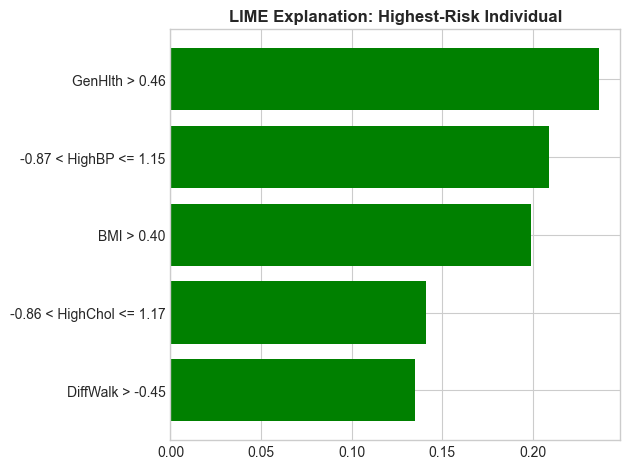


Explaining lowest-risk prediction...
P(At-Risk) = 0.007
Actual label: Healthy


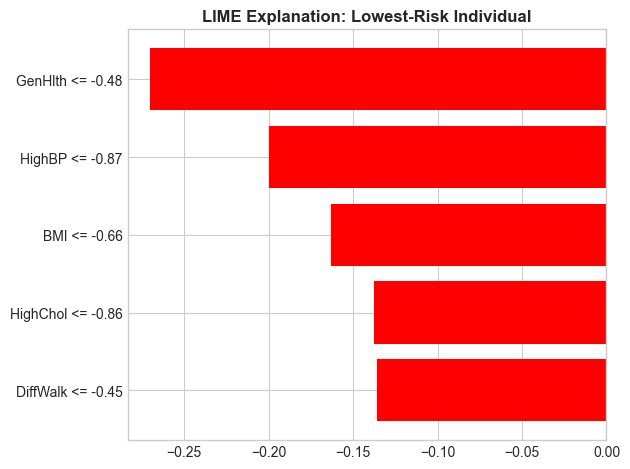

In [198]:
# LIME Analysis - Individual Prediction Explanation
print("LIME explanation for sample predictions...")

lime_explainer = LimeTabularExplainer(
    training_data=scaler_binary.transform(datasets[best_track]['X_train']),
    feature_names=selected_features,
    class_names=['Healthy', 'At-Risk'],
    mode='classification'
)

# Explain highest-risk prediction
sample_idx = np.argmax(y_proba_tuned[:, 1])
sample_scaled = X_test_scaled_binary[sample_idx]

print(f"\nExplaining highest-risk prediction...")
print(f"P(At-Risk) = {y_proba_tuned[sample_idx, 1]:.3f}")
print(f"Actual label: {'At-Risk' if datasets[best_track]['y_test'].iloc[sample_idx] == 1 else 'Healthy'}")

explanation = lime_explainer.explain_instance(
    sample_scaled,
    xgb_classifier_binary.predict_proba,
    num_features=10
)

fig = explanation.as_pyplot_figure()
plt.title('LIME Explanation: Highest-Risk Individual', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lime_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

# Explain lowest-risk prediction for comparison
healthy_idx = np.argmin(y_proba_tuned[:, 1])
healthy_scaled = X_test_scaled_binary[healthy_idx]

print(f"\nExplaining lowest-risk prediction...")
print(f"P(At-Risk) = {y_proba_tuned[healthy_idx, 1]:.3f}")
print(f"Actual label: {'At-Risk' if datasets[best_track]['y_test'].iloc[healthy_idx] == 1 else 'Healthy'}")

explanation_healthy = lime_explainer.explain_instance(
    healthy_scaled,
    xgb_classifier_binary.predict_proba,
    num_features=10
)

fig = explanation_healthy.as_pyplot_figure()
plt.title('LIME Explanation: Lowest-Risk Individual', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lime_low_risk.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.15 Summary Comparison Tables

In [199]:
# Summary Table 1: Staged Decision Results
print("=" * 60)
print("SUMMARY: Complete Staged Decision Pipeline")
print("=" * 60)

print("\n-- Stage 1: Binary vs Multiclass (Macro-F1) --")
s1_pivot = stage1_df.pivot_table(index='model', columns='formulation', values='macro_f1')
print(s1_pivot.round(4).to_string())
print(f"  Decision: {CHOSEN_FORMULATION.title()}")

print(f"\n-- Stage 2: Feature Set Comparison (Recall) --")
s2_pivot = stage2_df.pivot_table(index='model', columns='feature_set', values='macro_recall')
print(s2_pivot.round(4).to_string())
print(f"  Decision: {CHOSEN_FEATURES_NAME} ({len(CHOSEN_FEATURES)} features)")

print(f"\n-- Stage 3: Resampling Strategy (Recall) --")
s3_pivot = stage3_df.pivot_table(index='model', columns='resampling', values='macro_recall')
print(s3_pivot.round(4).to_string())
print(f"  Decision: {CHOSEN_MODEL_NAME} + {CHOSEN_RESAMPLING.upper()}")

print(f"\n-- Stage 4: Tuned Model --")
print(f"  Recall:   {metrics_tuned['macro_recall']:.4f}")
print(f"  Macro-F1: {metrics_tuned['macro_f1']:.4f}")
print(f"  ROC-AUC:  {metrics_tuned['roc_auc']:.4f}")

SUMMARY: Complete Staged Decision Pipeline

-- Stage 1: Binary vs Multiclass (Macro-F1) --
formulation          Binary  Multiclass
model                                  
Logistic Regression  0.5953      0.3868
Random Forest        0.5653      0.3657
XGBoost              0.6018      0.3915
  Decision: Binary

-- Stage 2: Feature Set Comparison (Recall) --
feature_set          Engineered  RFE-Selected     Raw
model                                                
Logistic Regression      0.5806        0.5707  0.5779
Random Forest            0.5610        0.5684  0.5571
XGBoost                  0.5781        0.5683  0.5823
  Decision: RFE-Selected (5 features)

-- Stage 3: Resampling Strategy (Recall) --
resampling           CLASS_WEIGHT    NONE     ROS   SMOTE
model                                                    
Logistic Regression        0.7262  0.5707  0.7262  0.7258
Random Forest              0.7271  0.5684  0.7272  0.7274
XGBoost                    0.7283  0.5683  0.7291  0.7275

In [200]:
# Final Model Summary
print("=" * 60)
print("FINAL MODEL: Binary Classification (At-Risk Detection)")
print("=" * 60)

print(f"\nModel:      {CHOSEN_MODEL_NAME}")
print(f"Resampling: {CHOSEN_RESAMPLING.upper()}")
print(f"Features:   {CHOSEN_FEATURES_NAME} ({len(CHOSEN_FEATURES)} features)")
if CHOSEN_TRACK == 'E':
    print(f"  Parsimonious feature set selected for interpretability.")

print(f"\nTest Performance:")
print(f"  Recall (PRIMARY):  {metrics_tuned['macro_recall']:.4f}")
print(f"  Macro-F1:          {metrics_tuned['macro_f1']:.4f}")
print(f"  ROC-AUC:           {metrics_tuned['roc_auc']:.4f}")
print(f"  Accuracy:          {metrics_tuned['accuracy']:.4f}")

print(f"\nCalibration:")
print(f"  Brier Score (sigmoid):  {brier_sigmoid:.4f}")
print(f"  Brier Score (isotonic): {brier_isotonic:.4f}")
print(f"  Optimal Threshold:      {optimal_threshold:.3f}")

print(f"\nTriage Distribution:")
_, final_actions = evaluate_triage(y_test_binary.values, best_proba, best_triage['low'], best_triage['high'])
for action, count in pd.Series(final_actions).value_counts().items():
    pct = count / len(final_actions) * 100
    print(f"  {action}: {count} ({pct:.1f}%)")

FINAL MODEL: Binary Classification (At-Risk Detection)

Model:      XGBoost
Resampling: ROS
Features:   RFE-Selected (5 features)
  Parsimonious feature set selected for interpretability.

Test Performance:
  Recall (PRIMARY):  0.7286
  Macro-F1:          0.6234
  ROC-AUC:           0.8039
  Accuracy:          0.7043

Calibration:
  Brier Score (sigmoid):  0.1104
  Brier Score (isotonic): 0.1091
  Optimal Threshold:      0.188

Triage Distribution:
  REVIEW: 28311 (55.8%)
  AUTO_HEALTHY: 22253 (43.9%)
  AUTO_AT_RISK: 172 (0.3%)


---
## 5.16 Save Predictions

In [201]:
# Save predictions with calibrated probabilities (binary only)
predictions_df = pd.DataFrame({
    'true_label': datasets[best_track]['y_test'].values,
    'predicted': y_pred_tuned,
    'probability_at_risk': y_proba_sigmoid  # Calibrated probabilities
})

predictions_df.to_csv(DATA_DIR / 'classification_predictions.csv', index=False)
print(f"Predictions saved to {DATA_DIR / 'classification_predictions.csv'}")
print(f"Feature set used: {best_track_name} ({len(selected_features)} features)")
if best_track == 'E':
    print(f"  Parsimonious model: fewer features for interpretability.")
predictions_df.head(10)

Predictions saved to data\classification_predictions.csv
Feature set used: Binary + RFE-Selected (5 features)
  Parsimonious model: fewer features for interpretability.


,true_label,predicted,probability_at_risk
0,0,1,0.156598
1,0,0,0.060619
2,0,0,0.114379
3,0,1,0.129129
4,0,0,0.067976
5,1,1,0.345003
6,0,1,0.267604
7,0,0,0.082228
8,0,1,0.201407
9,0,0,0.063868


---
## 5.17 Critical Reflection

The pipeline follows a staged decision-making approach, locking in each choice before proceeding. This avoids testing all combinations simultaneously and keeps the reasoning traceable.

Macro-F1 was used for the binary vs multiclass comparison (Stage 1) because it treats all classes fairly regardless of class count. Once binary was confirmed, recall became the primary metric (Stages 2--4) because minimising false negatives is the screening priority.

Binary classification outperformed multiclass. The multiclass formulation struggles with prediabetes due to its low prevalence (1.8%) and overlapping feature distributions with healthy individuals.

When recall was comparable across feature sets, fewer features were preferred. A parsimonious model is more transparent, easier to deploy, and less prone to overfitting.

High recall with moderate precision reflects the deliberate prioritisation of sensitivity. This is acceptable in a screening context where missed cases carry greater cost than unnecessary follow-up. Calibrated probabilities and cost-sensitive thresholds provide a mechanism for adjusting this trade-off.

Limitations include: ROC-AUC around 0.80 is reasonable for screening but insufficient for diagnosis; self-reported data introduces measurement noise; cross-sectional design cannot capture disease progression; and socioeconomic features may encode structural inequality.

---
## Summary of Staged Decisions

| Stage | Decision | Metric | Outcome |
|-------|----------|--------|---------|
| 1. Target Formulation | Binary vs Multiclass | Macro-F1 | Binary selected; multiclass cannot distinguish prediabetes (1.8% prevalence) |
| 2. Feature Selection | Engineered vs Raw vs RFE | Recall | Fewest features with comparable recall preferred for interpretability |
| 3. Resampling | None vs SMOTE vs ROS vs Class Weights | Recall | Best resampling strategy identified empirically |
| 4. Hyperparameter Tuning | GridSearchCV on winning model | Recall | Final model optimised for screening sensitivity |

Post-tuning steps: calibration, threshold optimisation, triage policy, and explainability (SHAP/LIME).